In [377]:
# importing essential libraries 

import yfinance as yf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from datetime import datetime,timedelta

# Set display options for Pandas
pd.set_option('display.max_colwidth', None)  # No max width restriction
pd.set_option('display.expand_frame_repr', False)  # Disable auto line-breaking for wide DataFrames


# defining symbols and dates 

stocks= np.array(['COL','CSL','FMG','FPH','JBH','RMD','SAR','TPM'])

num_stocks=len(symbols)

# close sheet 1 csv file edited and updated to https://docs.google.com/spreadsheets/d/1wzU0em0i8lTQfI2BOPbrvFYD8uILLKp99Q0N2n7dVYo/edit?usp=sharing

# creating dataframe to store the closing prices 

df_close= pd.read_csv('close - Sheet1.csv')

df_close.set_index('Date',inplace=True)

#for single iteration

# calculate log returns
log_returns=np.log(1+df_close.pct_change())
log_returns=log_returns.dropna()

# generating random weights
random_weights=np.array(np.random.random(num_stocks))
random_weights=random_weights/np.sum(random_weights)

#expected annualised return
exp_return=np.sum((log_returns.mean()*random_weights)*252)

#expected volatility
exp_volatility=np.sqrt(
    np.dot(random_weights.T,
           np.dot( log_returns.cov()*252,random_weights  
       )
    )
)

#calculating sharpe ratio, making clear that for australian stock market the risk free rate is arround 4%
risk_free_rate=0.04

sharpe_ratio= (exp_return-risk_free_rate)/exp_volatility

# for multiple iteration MONTE CARLO SIMULATION
num_iterations=10000

# preparing empty dataframe for storing results for multiple iterations
#for weights
weights_array=np.zeros((num_iterations,num_stocks))

# for returns
ret_array=np.zeros(num_iterations)

#for volatility
vol_array=np.zeros(num_iterations)

#for sharpe ratio
sharpe_array=np.zeros(num_iterations)

#simulation

for i in range(num_iterations):
    #weights
    weights=np.array(np.random.random(num_stocks))
    weights=weights/np.sum(weights)
    weights_array[i,:]=weights
    #returns
    exp_return=np.sum((log_returns.mean()*weights)*252)
    ret_array[i]=exp_return
    #volatilty
    exp_volatility=np.sqrt(
        np.dot(
            weights.T,np.dot(
                log_returns.cov()*252,weights
            )
        )
    )
    vol_array[i]=exp_volatility
    #sharpe ratio
    sharpe_ratio=(exp_return-risk_free_rate)/ exp_volatility
    sharpe_array[i]=sharpe_ratio

# combining all 
data=[ret_array,vol_array,sharpe_array,weights_array]
simulations_df=pd.DataFrame(data=data).T
simulations_df.columns=['Returns','Volatility','Sharpe Ratio','Weights']

#deciding metrics
#maximising sharpe ratio
max_sharpe=simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

#minimising volatilty
min_vol=simulations_df.loc[simulations_df['Volatility'].idxmin()]

# maximising return
max_return=simulations_df.loc[simulations_df['Returns'].idxmax()]

print('MAX SHARPE RATIO')
print('-'*80)
print(max_sharpe)


print('='*100)
print('MIN VOLATILITY')
print('-'*80)
print(min_vol)

print('='*100)
print('MAX RETURN')
print('-'*80)
print(max_return)





MAX SHARPE RATIO
--------------------------------------------------------------------------------
Returns                                                                                                                                                                          0.524963
Volatility                                                                                                                                                                       0.222146
Sharpe Ratio                                                                                                                                                                     2.183079
Weights         [0.09326357516830348, 0.05554505209743802, 0.1703105168452296, 0.47830343159416766, 0.027090219342081993, 0.03444132546322107, 0.11331351704328989, 0.027732362446268227]
Name: 1842, dtype: object
MIN VOLATILITY
--------------------------------------------------------------------------------
Returns                             

Text(0, 0.5, 'Returns')

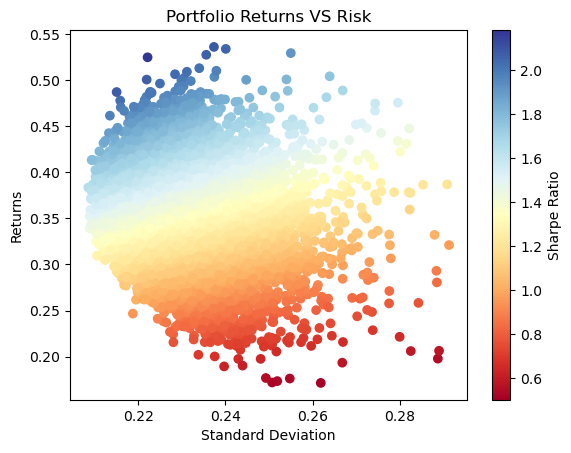

In [378]:
#plotting data on the basis of above metrics
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

plt.title('Portfolio Returns VS Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

USING SCIPY OPTIMIZATION 

In [380]:
#scipy optimization, getting metrics and minimization function

def get_metrics(weights:list)-> np.array:
    weights= np.array(weights)
    ret= np.sum((log_returns.mean()*weights)*252)
    vol= np.sqrt(
        np.dot(
            weights.T,np.dot(log_returns.cov()*252,weights)
        )
    )
    sr= (ret-risk_free_rate)/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights:list)-> np.array:
    return get_metrics(weights)[2]-1

def vol(weights:list)-> np.array:
    return get_metrics(weights)[1]

def check_sum(weights:list)->float:
    return np.sum(weights)-1

In [381]:
# setting bounds and constraints

bounds=tuple((0,1) for stocks in range(num_stocks))

constraints=({'type':'eq','fun':check_sum})

initial_guess=num_stocks*[1/num_stocks]

optimized_sharpe=sci_opt.minimize(
    neg_sharpe, #element to minimize
    initial_guess, # initial weights 
    method='SLSQP',
    bounds=bounds,
    constraints=constraints   
)

print('OPTIMIZED SHARPE')
print('-'*80)
print(optimized_sharpe)

print('='*100)





OPTIMIZED SHARPE
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.138988213083226
       x: [ 0.000e+00  0.000e+00  2.082e-15  5.107e-15  0.000e+00
            2.220e-16  0.000e+00  1.000e+00]
     nit: 2
     jac: [ 4.332e-01  1.031e+00  1.799e+00  1.671e+00  6.282e-01
            9.777e-01  7.116e-01  9.956e-02]
    nfev: 18
    njev: 2


In [382]:
# finding final results

optimized_metrics=get_metrics(weights=optimized_sharpe.x)

print('OPTIMIZED METRICS')
print('-'*80)
print(optimized_metrics)

print('='*100)


OPTIMIZED METRICS
--------------------------------------------------------------------------------
[-0.01584307  0.40178277 -0.13898821]


In [384]:
optimized_vol=sci_opt.minimize(
    vol, #element to minimize
    initial_guess, # initial weights 
    method='SLSQP',
    bounds=bounds,
    constraints=constraints   
)

print('OPTIMIZED VOLATILITY')
print('-'*80)
print(optimized_vol)

print('='*100)


OPTIMIZED VOLATILITY
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.20639022153878164
       x: [ 2.155e-01  3.494e-02  6.060e-02  2.932e-01  1.254e-01
            1.256e-01  8.228e-02  6.239e-02]
     nit: 7
     jac: [ 2.064e-01  2.067e-01  2.063e-01  2.065e-01  2.066e-01
            2.056e-01  2.064e-01  2.066e-01]
    nfev: 63
    njev: 7


In [390]:
# finding final results

optimized_metrics_1=get_metrics(weights=optimized_vol.x)

print('OPTIMIZED METRICS')
print('-'*80)
print(optimized_metrics_1)

print('='*100)


OPTIMIZED METRICS
--------------------------------------------------------------------------------
[0.38494517 0.20639022 1.67132516]


FROM ABOVE SCIPY OPTMIZATION TAKING SHARPE RATIO AS A METRIC CAN BE NOT PROFITABLE WHILE VOLATILITY GIVES US BETTER RESULT 
THEREFORE USING VOLATILITY AS A METRIC

In [393]:
print('WEIGHTS')
print('-'*80)
print(optimized_vol.x)

print('='*100)

print('RETURNS')
print('-'*80)
print(optimized_metrics_1[0])

print('='*100)

print('VOLATILITY')
print('-'*80)
print(optimized_metrics_1[1])

print('='*100)

print('SHARPE RATIO')
print('-'*80)
print(optimized_metrics_1[2])

print('='*100)

WEIGHTS
--------------------------------------------------------------------------------
[0.21554059 0.03494182 0.06060319 0.29315717 0.12543748 0.12564939
 0.08228251 0.06238784]
RETURNS
--------------------------------------------------------------------------------
0.38494516952812824
VOLATILITY
--------------------------------------------------------------------------------
0.20639022153878164
SHARPE RATIO
--------------------------------------------------------------------------------
1.671325157540526
